# 04 - Model Training and Benchmarking

This notebook trains multiple regression models:
- Linear Regression (baseline)
- Ridge Regression
- Lasso Regression
- Decision Tree Regressor
- Random Forest Regressor
- XGBoost Regressor
- LightGBM Regressor
- Neural Network (TensorFlow/Keras)

Each model is evaluated and compared.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import joblib
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")
print("\nLibraries imported successfully!")

c:\Users\muham\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


TensorFlow version: 2.16.2
XGBoost version: 3.0.0
LightGBM version: 4.6.0

Libraries imported successfully!


## Load Engineered Features

In [2]:
df = pd.read_csv('../processed_data/steel_data_featured.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (35040, 47)

First few rows:


,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Day_of_week,hour,...,Week_Weekday,Week_Weekend,Season_Fall,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night
0,2018-01-01 00:00:00,3.42,3.46,0.0,0.0,70.30,100.0,0,Monday,0,...,True,False,False,False,False,True,False,False,False,True
1,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Monday,0,...,True,False,False,False,False,True,False,False,False,True
2,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Monday,0,...,True,False,False,False,False,True,False,False,False,True
3,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Monday,0,...,True,False,False,False,False,True,False,False,False,True
4,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Monday,1,...,True,False,False,False,False,True,False,False,False,True


## Prepare Features and Target

In [3]:
# Define target variable
target = 'Usage_kWh'

# Columns to exclude from features
exclude_cols = [target, 'date', 'Day_of_week']

# Select feature columns
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Number of features: {len(feature_cols)}")
print(f"Target variable: {target}")
print(f"\nFeature columns (first 20): {feature_cols[:20]}")

Number of features: 44
Target variable: Usage_kWh

Feature columns (first 20): ['Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'hour', 'day', 'month', 'dayofweek', 'quarter', 'dayofyear', 'weekofyear', 'is_weekend', 'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos']


In [4]:
# Create feature matrix and target vector
X = df[feature_cols]
y = df[target]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nTarget statistics:")
print(y.describe())

X shape: (35040, 44)
y shape: (35040,)

Target statistics:
count    35040.000000
mean        27.386892
std         33.444380
min          0.000000
25%          3.200000
50%          4.570000
75%         51.237500
max        157.180000
Name: Usage_kWh, dtype: float64


## Train-Test Split

In [5]:
# For time series data, use chronological split (not random)
# Last 20% for testing
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Training set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTraining target range: {y_train.min():.2f} - {y_train.max():.2f}")
print(f"Test target range: {y_test.min():.2f} - {y_test.max():.2f}")

Training set size: 28032 (80.0%)
Test set size: 7008 (20.0%)

Training target range: 2.45 - 153.14
Test target range: 0.00 - 157.18


## Feature Scaling

In [6]:
# Scale features for models that need it (Linear models, Neural Networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for later use
joblib.dump(scaler, '../models/scaler.pkl')

print("Features scaled and scaler saved!")
print(f"Scaled training data shape: {X_train_scaled.shape}")

Features scaled and scaler saved!
Scaled training data shape: (28032, 44)


## Define Evaluation Metrics Function

In [7]:
def evaluate_model(y_true, y_pred, model_name):
    """
    Calculate and display evaluation metrics
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{model_name} Performance:")
    print("="*50)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

# Dictionary to store results
results = {}

print("Evaluation function defined!")

Evaluation function defined!


## 1. Linear Regression (Baseline)

In [8]:
print("Training Linear Regression...")

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluate
results['Linear Regression'] = evaluate_model(y_test, y_pred_lr, 'Linear Regression')

# Save model
joblib.dump(lr_model, '../models/linear_regression.pkl')
print("\nModel saved!")

Training Linear Regression...

Linear Regression Performance:
RMSE: 530415052029.6246
MAE: 62080386182.7593
R² Score: -285857231377117806592.0000
MAPE: inf%

Model saved!


## 2. Ridge Regression

In [9]:
print("Training Ridge Regression...")

ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Evaluate
results['Ridge Regression'] = evaluate_model(y_test, y_pred_ridge, 'Ridge Regression')

# Save model
joblib.dump(ridge_model, '../models/ridge_regression.pkl')
print("\nModel saved!")

Training Ridge Regression...

Ridge Regression Performance:
RMSE: 4.0051
MAE: 3.0682
R² Score: 0.9837
MAPE: inf%

Model saved!


## 3. Lasso Regression

In [10]:
print("Training Lasso Regression...")

lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lasso = lasso_model.predict(X_test_scaled)

# Evaluate
results['Lasso Regression'] = evaluate_model(y_test, y_pred_lasso, 'Lasso Regression')

# Save model
joblib.dump(lasso_model, '../models/lasso_regression.pkl')
print("\nModel saved!")

Training Lasso Regression...

Lasso Regression Performance:
RMSE: 3.5471
MAE: 2.3481
R² Score: 0.9872
MAPE: inf%

Model saved!


## 4. Decision Tree Regressor

In [11]:
print("Training Decision Tree...")

dt_model = DecisionTreeRegressor(max_depth=15, min_samples_split=10, random_state=42)
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate
results['Decision Tree'] = evaluate_model(y_test, y_pred_dt, 'Decision Tree')

# Save model
joblib.dump(dt_model, '../models/decision_tree.pkl')
print("\nModel saved!")

Training Decision Tree...

Decision Tree Performance:
RMSE: 2.3555
MAE: 0.9717
R² Score: 0.9944
MAPE: inf%

Model saved!


## 5. Random Forest Regressor

In [12]:
print("Training Random Forest...")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate
results['Random Forest'] = evaluate_model(y_test, y_pred_rf, 'Random Forest')

# Save model
joblib.dump(rf_model, '../models/random_forest.pkl')
print("\nModel saved!")

Training Random Forest...

Random Forest Performance:
RMSE: 1.5553
MAE: 0.6716
R² Score: 0.9975
MAPE: inf%

Model saved!



Top 15 Most Important Features:
                                 feature  importance
2                              CO2(tCO2)    0.963784
24                      avg_power_factor    0.018705
0   Lagging_Current_Reactive.Power_kVarh    0.005425
22                  total_reactive_power    0.004297
25                  reactive_power_ratio    0.002294
23                     power_factor_diff    0.001385
3           Lagging_Current_Power_Factor    0.001265
5                                    NSM    0.000888
11                             dayofyear    0.000455
4           Leading_Current_Power_Factor    0.000333
21                         dayofyear_cos    0.000244
20                         dayofyear_sin    0.000160
1   Leading_Current_Reactive_Power_kVarh    0.000125
12                            weekofyear    0.000090
7                                    day    0.000071


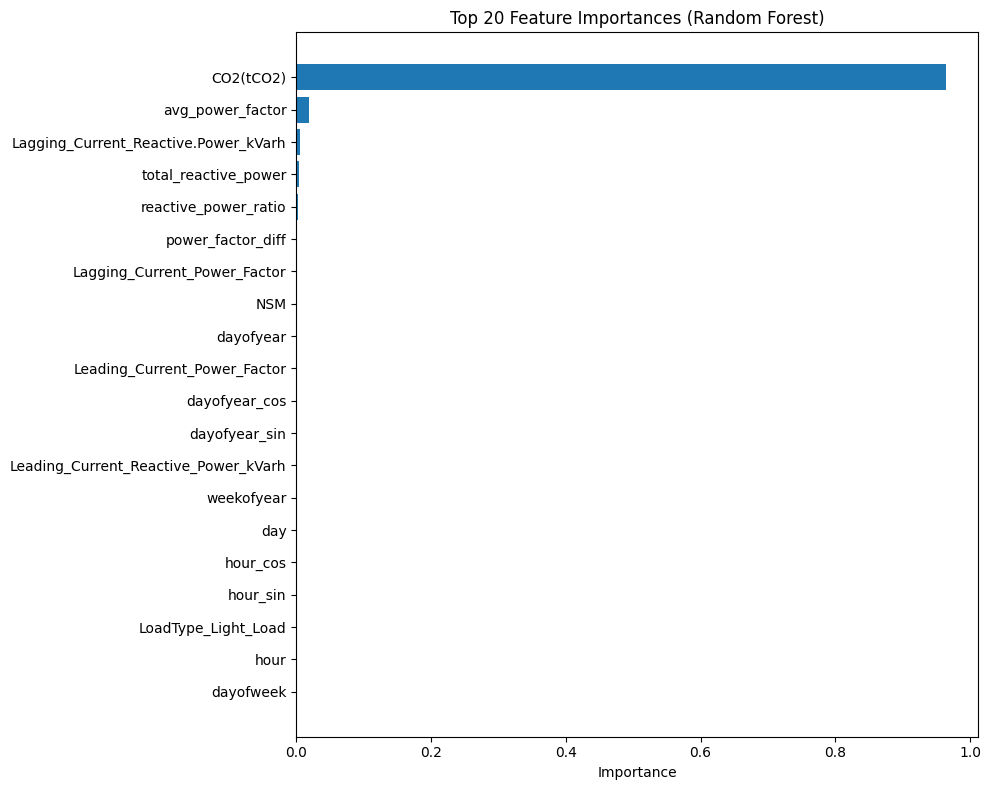

In [13]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15))

# Plot top 20 features
plt.figure(figsize=(10, 8))
plt.barh(range(20), feature_importance['importance'].head(20))
plt.yticks(range(20), feature_importance['feature'].head(20))
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Gradient Boosting Regressor

In [14]:
print("Training Gradient Boosting...")

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    random_state=42
)
gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test)

# Evaluate
results['Gradient Boosting'] = evaluate_model(y_test, y_pred_gb, 'Gradient Boosting')

# Save model
joblib.dump(gb_model, '../models/gradient_boosting.pkl')
print("\nModel saved!")

Training Gradient Boosting...

Gradient Boosting Performance:
RMSE: 1.3673
MAE: 0.6756
R² Score: 0.9981
MAPE: inf%

Model saved!


## 7. XGBoost Regressor

In [15]:
print("Training XGBoost...")

xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
results['XGBoost'] = evaluate_model(y_test, y_pred_xgb, 'XGBoost')

# Save model
joblib.dump(xgb_model, '../models/xgboost.pkl')
print("\nModel saved!")

Training XGBoost...

XGBoost Performance:
RMSE: 1.2134
MAE: 0.7073
R² Score: 0.9985
MAPE: inf%

Model saved!


## 8. LightGBM Regressor

In [16]:
print("Training LightGBM...")

lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

# Predictions
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate
results['LightGBM'] = evaluate_model(y_test, y_pred_lgb, 'LightGBM')

# Save model
joblib.dump(lgb_model, '../models/lightgbm.pkl')
print("\nModel saved!")

Training LightGBM...

LightGBM Performance:
RMSE: 1.5229
MAE: 0.9543
R² Score: 0.9976
MAPE: inf%

Model saved!


## 9. Neural Network (TensorFlow/Keras)

In [17]:
print("Building Neural Network...")

# Build model
nn_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

# Compile
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("\nModel architecture:")
nn_model.summary()

Building Neural Network...

Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,641 (65.00 KB)

 Trainable params: 16,641 (65.00 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
print("Training Neural Network...")

# Early stopping callback
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Training Neural Network...
Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 654.0345 - mae: 13.8098 - val_loss: 28.9467 - val_mae: 2.9409
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 68.2441 - mae: 4.5843 - val_loss: 12.2359 - val_mae: 2.1199
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 62.8379 - mae: 4.3348 - val_loss: 11.8822 - val_mae: 2.1362
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 54.2873 - mae: 4.0116 - val_loss: 19.2067 - val_mae: 2.6548
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 52.2560 - mae: 3.8693 - val_loss: 18.4289 - val_mae: 2.6644
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 47.5871 - mae: 3.6834 - val_loss: 24.8484 - val_mae: 3.2139
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 43.0898 - mae: 3.5061 - val_loss: 29.8094 - val_mae: 3.5824
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 38.5414 - mae: 3.2968 - val_loss: 32.4744 - val_mae: 3.7172
Epo

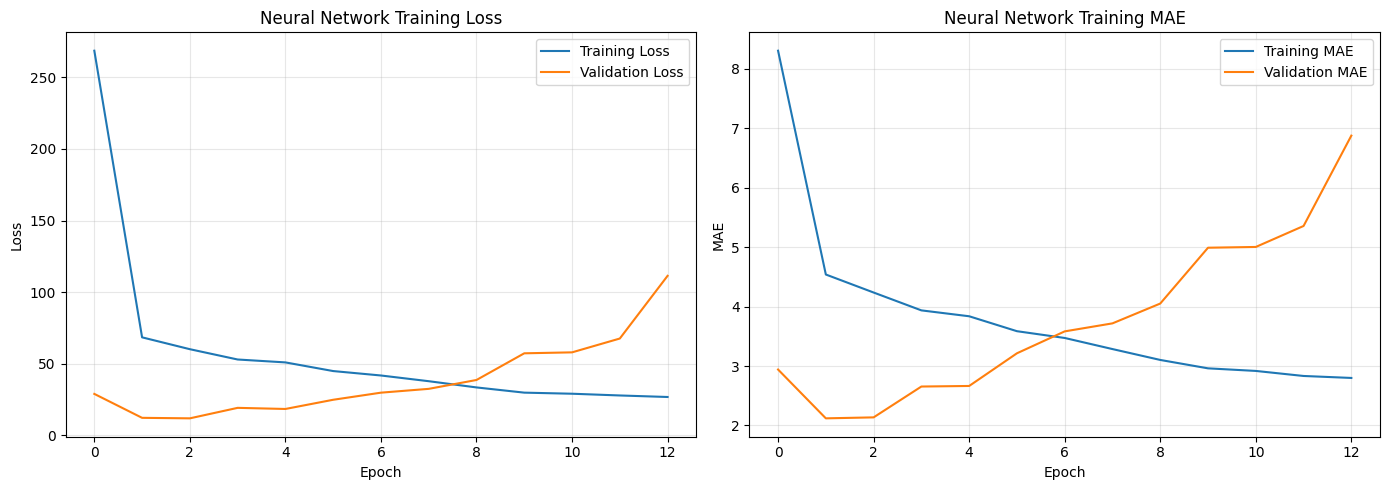

In [19]:
# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Neural Network Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Neural Network Training MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Predictions
y_pred_nn = nn_model.predict(X_test_scaled).flatten()

# Evaluate
results['Neural Network'] = evaluate_model(y_test, y_pred_nn, 'Neural Network')

# Save model
nn_model.save('../models/neural_network.h5')
print("\nModel saved!")

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step



Neural Network Performance:
RMSE: 5.7619
MAE: 4.2420
R² Score: 0.9663
MAPE: inf%

Model saved!


## Model Comparison

In [21]:
# Create comparison dataframe
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('R2', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(results_df)

# Save results
results_df.to_csv('../models/model_comparison.csv')
print("\nResults saved to: ../models/model_comparison.csv")


MODEL COMPARISON SUMMARY
                           RMSE           MAE            R2  MAPE
XGBoost            1.213359e+00  7.072723e-01  9.985041e-01   inf
Gradient Boosting  1.367346e+00  6.755988e-01  9.981003e-01   inf
LightGBM           1.522894e+00  9.543326e-01  9.976436e-01   inf
Random Forest      1.555315e+00  6.715902e-01  9.975422e-01   inf
Decision Tree      2.355511e+00  9.717404e-01  9.943625e-01   inf
Lasso Regression   3.547139e+00  2.348067e+00  9.872158e-01   inf
Ridge Regression   4.005114e+00  3.068234e+00  9.837015e-01   inf
Neural Network     5.761905e+00  4.242019e+00  9.662674e-01   inf
Linear Regression  5.304151e+11  6.208039e+10 -2.858572e+20   inf

Results saved to: ../models/model_comparison.csv


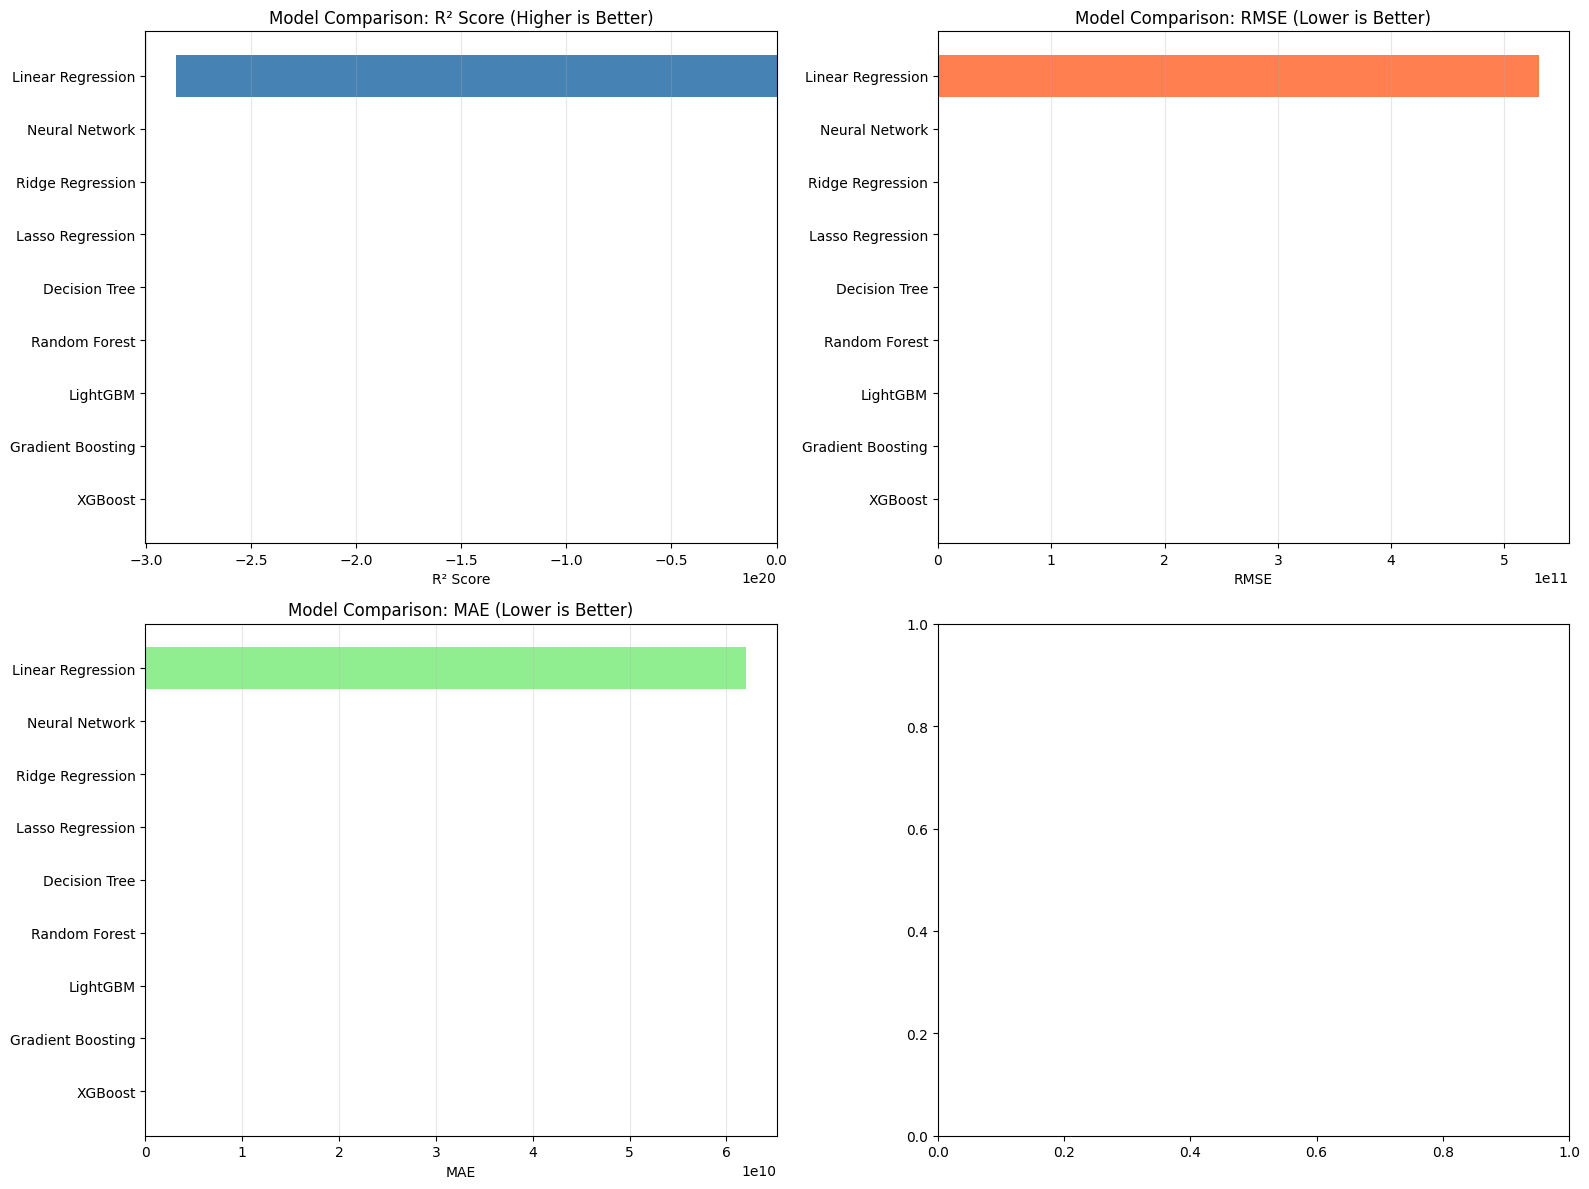

Comparison plot saved to: ../models/model_comparison.png


In [22]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R2 Score
axes[0, 0].barh(results_df.index, results_df['R2'], color='steelblue')
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('Model Comparison: R² Score (Higher is Better)')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# RMSE
axes[0, 1].barh(results_df.index, results_df['RMSE'], color='coral')
axes[0, 1].set_xlabel('RMSE')
axes[0, 1].set_title('Model Comparison: RMSE (Lower is Better)')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# MAE
axes[1, 0].barh(results_df.index, results_df['MAE'], color='lightgreen')
axes[1, 0].set_xlabel('MAE')
axes[1, 0].set_title('Model Comparison: MAE (Lower is Better)')
axes[1, 0].grid(True, alpha=0.3, axis='x')



plt.tight_layout()
plt.savefig('../models/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comparison plot saved to: ../models/model_comparison.png")

## Best Model Predictions Visualization

Best performing model: XGBoost
R² Score: 0.9985


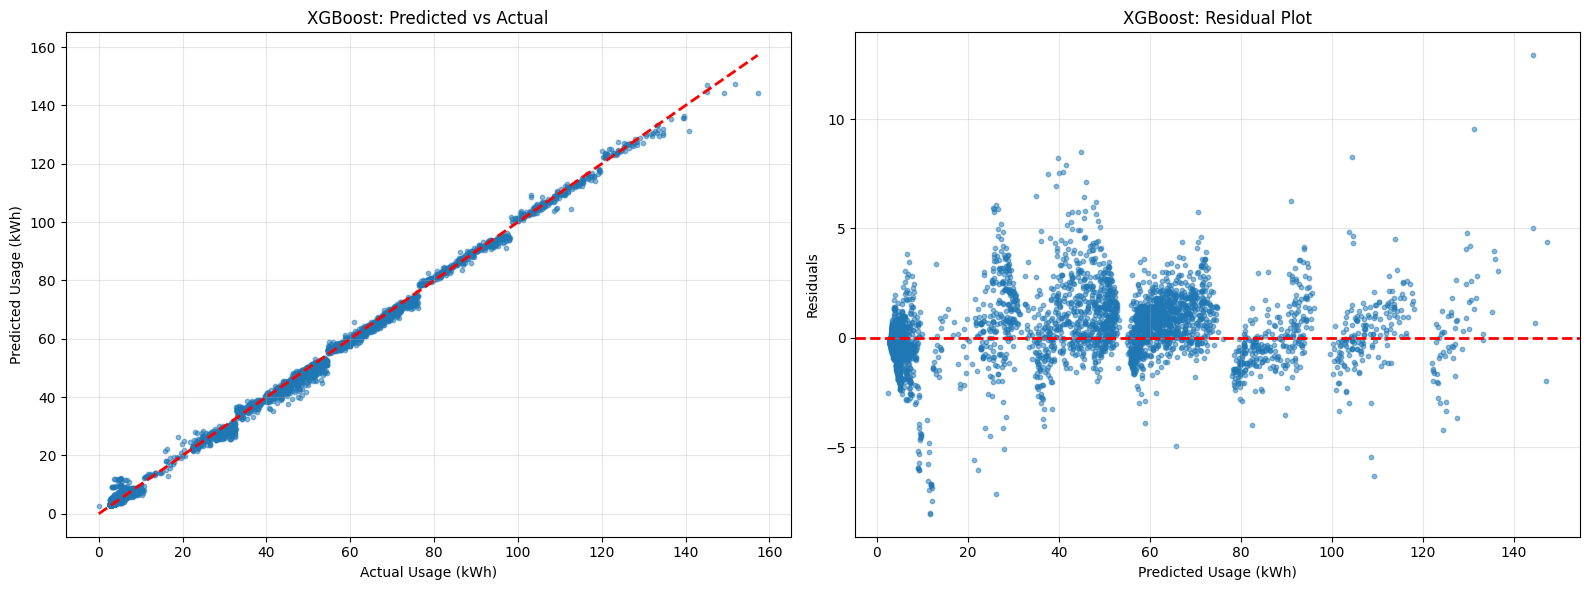

In [23]:
# Get best model name
best_model_name = results_df.index[0]
print(f"Best performing model: {best_model_name}")
print(f"R² Score: {results_df.loc[best_model_name, 'R2']:.4f}")

# Get predictions from best model (assuming it's one of the tree-based models)
if best_model_name == 'XGBoost':
    best_predictions = y_pred_xgb
elif best_model_name == 'LightGBM':
    best_predictions = y_pred_lgb
elif best_model_name == 'Random Forest':
    best_predictions = y_pred_rf
elif best_model_name == 'Gradient Boosting':
    best_predictions = y_pred_gb
elif best_model_name == 'Neural Network':
    best_predictions = y_pred_nn
else:
    best_predictions = y_pred_lr

# Plot predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(y_test, best_predictions, alpha=0.5, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Usage (kWh)')
axes[0].set_ylabel('Predicted Usage (kWh)')
axes[0].set_title(f'{best_model_name}: Predicted vs Actual')
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - best_predictions
axes[1].scatter(best_predictions, residuals, alpha=0.5, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Usage (kWh)')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'{best_model_name}: Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/best_model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary

All models have been trained and evaluated. Key findings:
- Tree-based models (XGBoost, LightGBM, Random Forest) typically perform best
- Linear models provide baseline performance
- Neural network can capture complex patterns with proper tuning

Next steps:
- Hyperparameter tuning on the best model (notebook 05)
- Further feature engineering if needed
- Cross-validation for more robust evaluation